In [2]:
import numpy as np
import torch
import random

import matplotlib.pyplot as plt


import torch
from torch import nn, optim
from torch import load
from torch.nn import functional as F
from torch import autograd

from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

#from ..easy_ntk import calculate_NTK
from einops import rearrange

import time

import sys
from pathlib import Path

from numba import njit
from numba.typed import List

%matplotlib inline

In [3]:
SEED = 0

In [4]:
import copy

def _del_nested_attr(obj, names):
    """
    Deletes the attribute specified by the given list of names.
    For example, to delete the attribute obj.conv.weight,
    use _del_nested_attr(obj, ['conv', 'weight'])
    """
    if len(names) == 1:
        delattr(obj, names[0])
    else:
        _del_nested_attr(getattr(obj, names[0]), names[1:])

def _set_nested_attr(obj, names, value):
    """
    Set the attribute specified by the given list of names to value.
    For example, to set the attribute obj.conv.weight,
    use _del_nested_attr(obj, ['conv', 'weight'], value)
    """
    if len(names) == 1:
        setattr(obj, names[0], value)
    else:
        _set_nested_attr(getattr(obj, names[0]), names[1:], value)

def extract_weights(mod):
    """
    This function removes all the Parameters from the model and
    return them as a tuple as well as their original attribute names.
    The weights must be re-loaded with `load_weights` before the model
    can be used again.
    Note that this function modifies the model in place and after this
    call, mod.parameters() will be empty.
    """
    orig_params = tuple(mod.parameters())
    # Remove all the parameters in the model
    names = []
    for name, p in list(mod.named_parameters()):
        _del_nested_attr(mod, name.split("."))
        names.append(name)

    # Make params regular Tensors instead of nn.Parameter
    params = tuple(p.detach().requires_grad_() for p in orig_params)
    return params, names

def load_weights(mod, names, params):
    """
    Reload a set of weights so that `mod` can be used again to perform a forward pass.
    Note that the `params` are regular Tensors (that can have history) and so are left
    as Tensors. This means that mod.parameters() will still be empty after this call.
    """
    for name, p in zip(names, params):
        _set_nested_attr(mod, name.split("."), p)
        
def calculate_NTK(model,x,device='cpu',MODE='samples'):
    """
    INPUTS:
        model: torch.nn.Module 
        x: torch.Tensor
        device: 'cpu',
        MODE: 'minima'
    
    OUTPUTS:
        NTK: torch.Tensor
    
    Calculates the NTK for a model, p_dict a state dictionary, and x, a single tensor fed into the model
    
    The NTK is the grammian of the Jacobian of the model output to w.r.t. the weights of the model
    
    This function will output the NTK such that the minima matrix size is used. If the Jacobian is an NxM
    matrix, then the NTK is formulated so that if N < M; NTK is NxN. If M<N, then NTK is MxM.
    
    #EXAMPLE USAGE:
    device='cpu'
    model = MODEL() #a torch.nn.Module object 
    model.to(device)
    state_dict = model.state_dict()

    x_test = np.ones((100,1,28,28),dtype=np.float32)
    x_test = torch.from_numpy(x_test)

    NTK = calculate_NTK(model,x_test)
    """
    if not(MODE in ['minima','samples','params']):
        raise ValueError("MODE must be one of 'minima','samples','params'")
    
    x = x.to(device)
    x.requires_grad=False
    N = x.shape[0]
    M = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    #We need to create a clone of the model or else we make it unusable as part of the trickery 
    #to get pytorch to do what we want. Unforutantely, this exlcludes super big models. but, eh.
    model_clone = copy.deepcopy(model)
    
    params, names = extract_weights(model_clone)
    def model_ntk(*args,model=model_clone, names=names):
        params = tuple(args)
        load_weights(model, names, params)
        return model(x)
    
    Js = torch.autograd.functional.jacobian(model_ntk, tuple(params), create_graph=False, vectorize=True)
    
    Js = list(Js)
    #Js = [element for tupl in Js for element in tupl]
    #collapse the tensors
    for i,tensor in enumerate(Js):
        Js[i] = tensor.reshape(N,-1)
    
    J = torch.cat(Js,axis=1)
    
    if MODE=='minima':
        if N < M: #if datasize points is less than number of parameters:
            NTK = torch.matmul(J,J.T)

        if N >= M:#if number of parameters is less than datasize:
            NTK = torch.matmul(J.T,J)
    elif MODE=='samples':
        NTK = torch.matmul(J,J.T)
    elif MODE=='params':
        NTK = torch.matmul(J.T,J)
    
    return NTK

In [5]:

# #Identity
# def activation(x):
#     return x

# @njit
# def d_activation(x):
#     return np.ones(np.shape(x),dtype=np.float32) 


# #Tanh
def activation(x):
    return torch.tanh(x)

@njit
def d_activation(x):
    return np.cosh(x)**-2

In [6]:
def NTK_weights(m):
    if isinstance(m, nn.Linear):
        print(m.weight.shape)
        nn.init.normal_(m.weight.data)#/m.weight.shape[0]
        if m.bias != None:
            nn.init.normal_(m.bias.data)#/m.weight.shape[0]
    if isinstance(m, nn.Conv2d):
        print(m.weight.shape)
        nn.init.normal_(m.weight.data)#/m.weight.shape[0]
        if m.bias != None:
            nn.init.normal_(m.bias.data)#/m.weight.shape[0]

In [7]:
7*7*8

392

In [8]:
class Simple_Conv(torch.nn.Module):
    '''
    simple network for test cases
    
    
    It seems like bias vectors aren't trivially added.
    '''
    def __init__(self,):
        super(Simple_Conv, self).__init__()
        #input size=(N,1,28,28)
        self.d1 = torch.nn.Conv2d(1,4,3,stride=2,padding=1,bias=False)

        self.d2 = torch.nn.Conv2d(4,8,3,stride=2,padding=1,bias=False)
        
        self.d3 = torch.nn.Linear(7*7*8,32,bias=False)
        
        self.d4 = torch.nn.Linear(32,1,bias=False)
        
    def forward(self, x):
        x = 1/np.sqrt(3*3*4) * activation(self.d1(x))
        x = 1/np.sqrt(3*3*8) * activation(self.d2(x))
        x = x.reshape(-1,7*7*8)
        x = 1/np.sqrt(32) * activation(self.d3(x))
        x = self.d4(x)
        return x

In [9]:
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)
device='cpu'

model_small = Simple_Conv()
model_small.to(device)
model_small.apply(NTK_weights)

x_test = np.random.normal(0,1,(128,1,28,28)).astype(np.float32) #n c_in, h, w
x_test = torch.from_numpy(x_test)

torch.Size([4, 1, 3, 3])
torch.Size([8, 4, 3, 3])
torch.Size([32, 392])
torch.Size([1, 32])


# NTK Easy, (to make sure the convolutional network we designate is being correctly computed by our layerwise autograd method)

In [10]:
NTK_easy = calculate_NTK(model_small,x_test).detach().numpy()

# Find Components with autograd

In [11]:
model_small.zero_grad()
y = model_small(x_test)

layer_components_w1 = [] 
layer_components_w2 = []
layer_components_w3 = []
layer_components_w4 = []

for output in y:
    model_small.zero_grad()
    
    output.backward(retain_graph=True)

    #Get the tensors
    w1_grad = model_small.d1.weight.grad.detach().numpy()
    w2_grad = model_small.d2.weight.grad.detach().numpy()
    w3_grad = model_small.d3.weight.grad.detach().numpy()
    w4_grad = model_small.d4.weight.grad.detach().numpy()

    #reshape and append. deep copy neccessary or else they are the same objects
    layer_components_w1.append(w1_grad.reshape(-1).copy())
    layer_components_w2.append(w2_grad.reshape(-1).copy())
    layer_components_w3.append(w3_grad.reshape(-1).copy())
    layer_components_w4.append(w4_grad.reshape(-1).copy())

In [12]:
layer_components_w1 = np.array(layer_components_w1)
layer_components_w2 = np.array(layer_components_w2)
layer_components_w3 = np.array(layer_components_w3)
layer_components_w4 = np.array(layer_components_w4)

In [13]:
autograd_NTK = layer_components_w1 @ layer_components_w1.T+\
    layer_components_w2 @ layer_components_w2.T+\
    layer_components_w3 @ layer_components_w3.T+\
    layer_components_w4 @ layer_components_w4.T

In [14]:
print(np.allclose(autograd_NTK,NTK_easy,rtol=1e-3)) #The numbers contained in the NTK have very disparate values... rtol
#can handle that better. 

maximum_difference_index = np.unravel_index(np.argmax(abs(autograd_NTK - NTK_easy)),np.shape(autograd_NTK))

print('maximum_difference: ',abs(autograd_NTK - NTK_easy)[maximum_difference_index])
print('maximum difference index og array values: ',autograd_NTK[maximum_difference_index],NTK_easy[maximum_difference_index])

True
maximum_difference:  1.66893e-06
maximum difference index og array values:  3.9586504 3.9586487


# Because the Autograd method agrees with the easy NTK method, we can feel secure in analyzing the components

In [15]:
l1_NTK = layer_components_w1 @ layer_components_w1.T
l2_NTK = layer_components_w2 @ layer_components_w2.T
l3_NTK = layer_components_w3 @ layer_components_w3.T
l4_NTK = layer_components_w4 @ layer_components_w4.T

### Full NTK

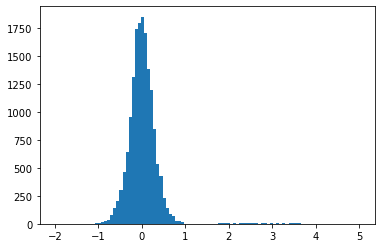

In [16]:
plt.hist(autograd_NTK.flatten(),bins=np.linspace(-2,5,100))
plt.show()

(array([75., 19., 11.,  7.,  5.,  4.,  2.,  2.,  2.,  1.]),
 array([ 0.317283 ,  1.8301556,  3.343028 ,  4.855901 ,  6.3687735,
         7.8816457,  9.394519 , 10.907391 , 12.420263 , 13.933136 ,
        15.446009 ], dtype=float32),
 <BarContainer object of 10 artists>)

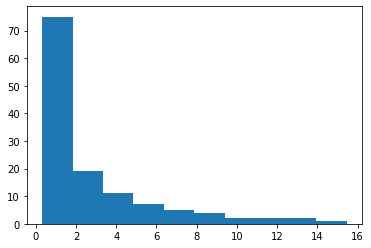

In [17]:
plt.hist(np.linalg.eigh(autograd_NTK)[0])

### Histogram and QQ plot

Min:  -1.0642192
Max:  2.871117
Median:  -0.0001794912
Mean:  0.008502591
MAD:  0.2107512140393257
STD:  0.26028508
 


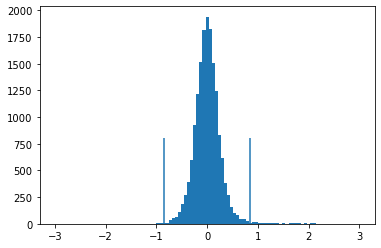

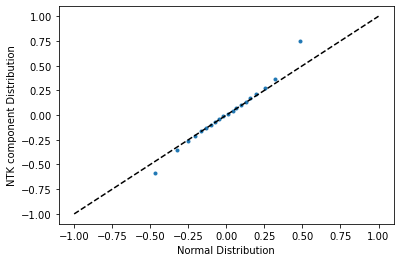

In [18]:
A = l1_NTK
MAD = 1.4826*np.median(np.abs(A-np.median(A)))
MED = np.median(A)
print('Min: ',np.min(A))
print('Max: ',np.max(A))
print('Median: ',np.median(A))
print('Mean: ',np.mean(A))
print('MAD: ',1.4826*np.median(np.abs(A-np.median(A))))
print('STD: ',np.std(A))
print(' ')

plt.hist(A.flatten(),bins=np.linspace(-3,3,100))
plt.vlines([MED-4*MAD,MED+4*MAD],0,800)
plt.show()

quantiles_of_normal = np.quantile(np.random.normal(np.median(A),1.4826*np.median(np.abs(A-np.median(A))),(1000)),np.linspace(0.01,0.99,20))
quantiles_of_distribution = np.quantile(A,np.linspace(0.01,0.99,20))

plt.plot(quantiles_of_normal,quantiles_of_distribution,'.')
plt.plot([-1,1],[-1,1],'k--')
plt.xlabel('Normal Distribution')
plt.ylabel('NTK component Distribution')
plt.show()

Min:  -0.1743128
Max:  0.9647641
Median:  0.000504049
Mean:  0.003784738
MAD:  0.040030537948384876
STD:  0.061839547
 


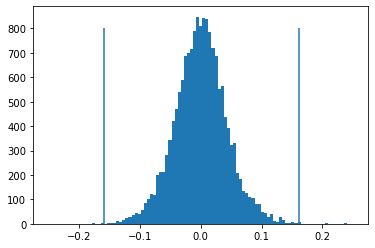

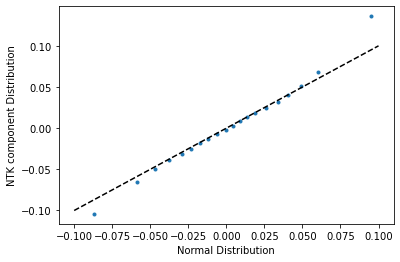

In [19]:
A = l2_NTK
MAD = 1.4826*np.median(np.abs(A-np.median(A)))
MED = np.median(A)
print('Min: ',np.min(A))
print('Max: ',np.max(A))
print('Median: ',np.median(A))
print('Mean: ',np.mean(A))
print('MAD: ',1.4826*np.median(np.abs(A-np.median(A))))
print('STD: ',np.std(A))
print(' ')

plt.hist(A.flatten(),bins=np.linspace(-0.25,0.25,100))
plt.vlines([MED-4*MAD,MED+4*MAD],0,800)
plt.show()

quantiles_of_normal = np.quantile(np.random.normal(np.median(A),1.4826*np.median(np.abs(A-np.median(A))),(1000)),np.linspace(0.01,0.99,20))
quantiles_of_distribution = np.quantile(A,np.linspace(0.01,0.99,20))

plt.plot(quantiles_of_normal,quantiles_of_distribution,'.')
plt.plot([-0.1,0.1],[-0.1,0.1],'k--')
plt.xlabel('Normal Distribution')
plt.ylabel('NTK component Distribution')
plt.show()

Min:  -0.11139735
Max:  0.79169047
Median:  5.3437238e-05
Mean:  0.0036569335
MAD:  0.023098585425317286
STD:  0.051624797
 


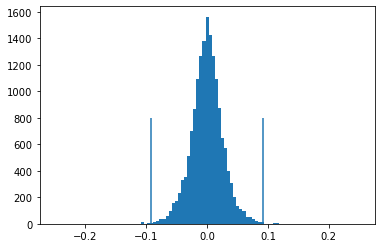

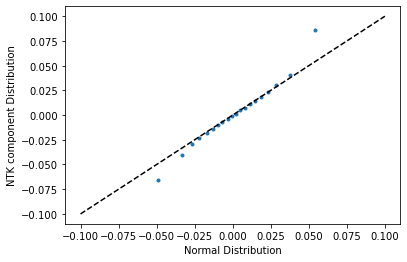

In [20]:
A = l3_NTK
MAD = 1.4826*np.median(np.abs(A-np.median(A)))
MED = np.median(A)
print('Min: ',np.min(A))
print('Max: ',np.max(A))
print('Median: ',np.median(A))
print('Mean: ',np.mean(A))
print('MAD: ',1.4826*np.median(np.abs(A-np.median(A))))
print('STD: ',np.std(A))
print(' ')

plt.hist(A.flatten(),bins=np.linspace(-0.25,0.25,100))
plt.vlines([MED-4*MAD,MED+4*MAD],0,800)
plt.show()

quantiles_of_normal = np.quantile(np.random.normal(np.median(A),1.4826*np.median(np.abs(A-np.median(A))),(1000)),np.linspace(0.01,0.99,20))
quantiles_of_distribution = np.quantile(A,np.linspace(0.01,0.99,20))

plt.plot(quantiles_of_normal,quantiles_of_distribution,'.')
plt.plot([-0.1,0.1],[-0.1,0.1],'k--')
plt.xlabel('Normal Distribution')
plt.ylabel('NTK component Distribution')
plt.show()

Min:  -0.3280837
Max:  0.65529174
Median:  -9.043842e-05
Mean:  0.0030808137
MAD:  0.09879337901473045
STD:  0.10466915
 


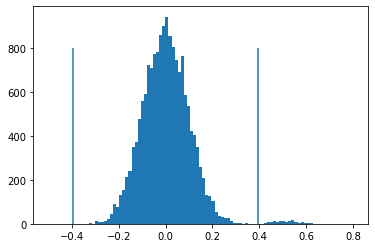

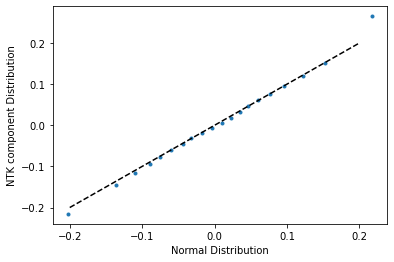

In [21]:
A = l4_NTK

MAD = 1.4826*np.median(np.abs(A-np.median(A)))
MED = np.median(A)

print('Min: ',np.min(A))
print('Max: ',np.max(A))
print('Median: ',np.median(A))
print('Mean: ',np.mean(A))
print('MAD: ',1.4826*np.median(np.abs(A-np.median(A))))
print('STD: ',np.std(A))
print(' ')

plt.hist(A.flatten(),bins=np.linspace(-0.5,0.8,100))
plt.vlines([MED-4*MAD,MED+4*MAD],0,800)
plt.show()

quantiles_of_normal = np.quantile(np.random.normal(np.median(A),1.4826*np.median(np.abs(A-np.median(A))),(1000)),np.linspace(0.01,0.99,20))
quantiles_of_distribution = np.quantile(A,np.linspace(0.01,0.99,20))

plt.plot(quantiles_of_normal,quantiles_of_distribution,'.')

plt.plot([-0.2,0.2],[-0.2,0.2],'k--')
plt.xlabel('Normal Distribution')
plt.ylabel('NTK component Distribution')
plt.show()

# Discussion on Histogram:

the number of outliers changes for each layer. According to the interpretation that we have on wikipedia, these are outliers of 'influence.'

Each row of the NTK tells us the contributing influence on the value of x from the other datapoints, xi. so the column number tell us that column index datapoint has above average influence on the output of the neural network towards row index value x.

The fact that the NTK's value follow a normal distribution shouldn't be surprising given we have used synthetic data. The fact that there are outliers at all is actually very confusing....? How can normally distributed data have any undue influence on any other datapoint. 

Given the above we have a few questions:

* Are the same indices outliers in all the layers? or do the outliers change?
* How are x values similar or different to another? Naively, maybe these are just relatively close values?
* Do these amount to the same outliers in the full NTK?
* What is the meaning of a bulk decrease or increase in the spread of the distribution?

* are the outliers shared between the full NTK and these components?
* Are the NTK outliers predominately the diagonal elements?
* repeat the analysis for Feed Forward
* repeat the analysis on MNIST
* Are we sure the equation in the wikipedia article is correct?


Also, we should run a gradient update and make sure the equation listed on wikiedia is actually true. 

### but First, lets look at the Eigenvalues, because why not

In [22]:
np.all(l1_NTK == l1_NTK.T)

True

2.2316136e-18
183.73294


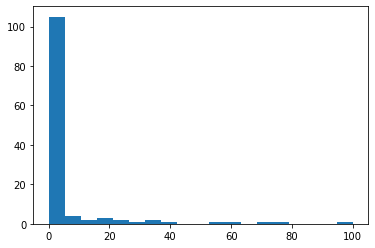

In [23]:
#I believe that np.linalg.eigh is running into some numerical problems, luckily, beacuse NTK are composed of
#gram matrices we know that the eigenvalues are positive semi-definite. That means we can compute the singular
#values and square them, which will atleast numerically agree that all the eigenvalues are positive
eig_l1 = np.linalg.svd(l1_NTK)[1]
eig_l1 = eig_l1**2

print(np.min(eig_l1))
print(np.max(eig_l1))
plt.hist(eig_l1,bins=np.linspace(0,100,20))
#plt.xscale('log')
plt.show()

0.0007380894
5.2819815


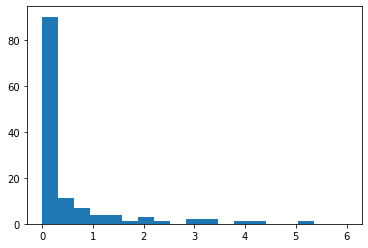

In [24]:
#I believe that np.linalg.eigh is running into some numerical problems, luckily, beacuse NTK are composed of
#gram matrices we know that the eigenvalues are positive semi-definite. That means we can compute the singular
#values and square them, which will atleast numerically agree that all the eigenvalues are positive
eig_l2 = np.linalg.svd(l2_NTK)[1]
eig_l2 = eig_l2**2

print(np.min(eig_l2))
print(np.max(eig_l2))
plt.hist(eig_l2,bins=np.linspace(0,6,20))
#plt.xscale('log')
plt.show()

0.015169455
2.453462


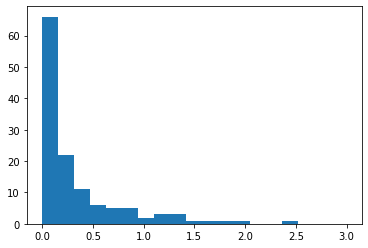

In [25]:
#I believe that np.linalg.eigh is running into some numerical problems, luckily, beacuse NTK are composed of
#gram matrices we know that the eigenvalues are positive semi-definite. That means we can compute the singular
#values and square them, which will atleast numerically agree that all the eigenvalues are positive
eig_l3 = np.linalg.svd(l3_NTK)[1]
eig_l3 = eig_l3**2

print(np.min(eig_l3))
print(np.max(eig_l3))
plt.hist(eig_l3,bins=np.linspace(0,3,20))
plt.show()

1.0253307e-18
24.850464


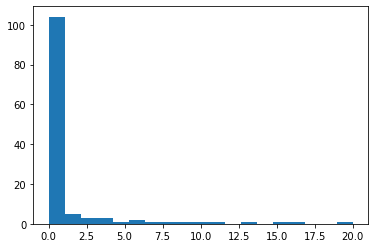

In [26]:
#I believe that np.linalg.eigh is running into some numerical problems, luckily, beacuse NTK are composed of
#gram matrices we know that the eigenvalues are positive semi-definite. That means we can compute the singular
#values and square them, which will atleast numerically agree that all the eigenvalues are positive
eig_l4 = np.linalg.svd(l4_NTK)[1]
eig_l4 = eig_l4**2

print(np.min(eig_l4))
print(np.max(eig_l4))
plt.hist(eig_l4,bins=np.linspace(0,20,20))
plt.show()

# Eh...

### lets go back to the NTK values. To be systematic, we will identify all the indices in each layer that are 3 sigma MAD outliers. Then, we can look for hits across using these masks and logical_and.

In [27]:
KAPPA = 4 #Number of MADs to be an outlier

A = l1_NTK
MED = np.median(A)
MAD = 1.4826*np.median(np.abs(A-np.median(A)))
MAD_mask_l1 = np.logical_or(A>KAPPA*MAD+MED,A<MED-KAPPA*MAD)
print('number of 3-sigma outliers: ',np.sum(MAD_mask_l1))

A = l2_NTK
MED = np.median(A)
MAD = 1.4826*np.median(np.abs(A-np.median(A)))
MAD_mask_l2 = np.logical_or(A>KAPPA*MAD+MED,A<MED-KAPPA*MAD)
print('number of 3-sigma outliers: ',np.sum(MAD_mask_l2))

A = l3_NTK
MED = np.median(A)
MAD = 1.4826*np.median(np.abs(A-np.median(A)))
MAD_mask_l3 = np.logical_or(A>KAPPA*MAD+MED,A<MED-KAPPA*MAD)
print('number of 3-sigma outliers: ',np.sum(MAD_mask_l3))

A = l4_NTK
MED = np.median(A)
MAD = 1.4826*np.median(np.abs(A-np.median(A)))
MAD_mask_l4 = np.logical_or(A>KAPPA*MAD+MED,A<MED-KAPPA*MAD)
print('number of 3-sigma outliers: ',np.sum(MAD_mask_l4))

print(' ')
print('Number of Hits, l1 and l2: ',np.sum(np.logical_and(MAD_mask_l1,MAD_mask_l2)))
print('Number of Hits, l2 and l3: ',np.sum(np.logical_and(MAD_mask_l2,MAD_mask_l3)))
print('Number of Hits, l3 and l4: ',np.sum(np.logical_and(MAD_mask_l3,MAD_mask_l4)))
print(' ')
print('Number of Hits, l1 and l3: ',np.sum(np.logical_and(MAD_mask_l1,MAD_mask_l3)))
print('Number of Hits, l1 and l4: ',np.sum(np.logical_and(MAD_mask_l1,MAD_mask_l4)))
print('Number of Hits, l2 and l4: ',np.sum(np.logical_and(MAD_mask_l2,MAD_mask_l4)))

print(' ')
print('probability of being an outlier in l2 if in l1: {:.3}'.format(np.sum(np.logical_and(MAD_mask_l1,MAD_mask_l2)/np.sum(MAD_mask_l1))))
print('probability of being an outlier in l2: {:.3}'.format(np.sum(MAD_mask_l2)/len(MAD_mask_l2.flatten())))

number of 3-sigma outliers:  136
number of 3-sigma outliers:  138
number of 3-sigma outliers:  160
number of 3-sigma outliers:  127
 
Number of Hits, l1 and l2:  94
Number of Hits, l2 and l3:  128
Number of Hits, l3 and l4:  127
 
Number of Hits, l1 and l3:  94
Number of Hits, l1 and l4:  93
Number of Hits, l2 and l4:  127
 
probability of being an outlier in l2 if in l1: 0.691
probability of being an outlier in l2: 0.00842


### Which means that the probability of being an outlier given already having been an outlier in one layer is substantially higher than being identified as an outlier from the entire group.

### i.e., outlier are more typically shared between layers-- its probably a characteristic of the data rather than the layer


#### so can we identify this characteristic?

In [28]:
x_test.shape

torch.Size([128, 1, 28, 28])

In [29]:
i_index

NameError: name 'i_index' is not defined

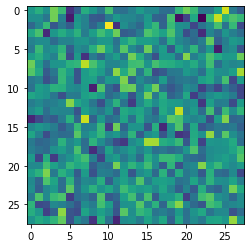

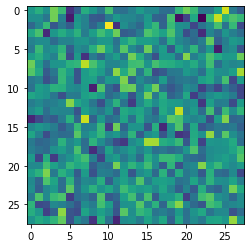

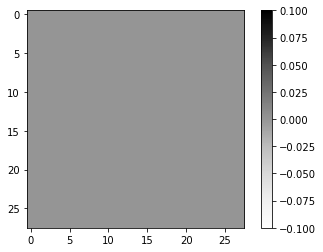

Corr coef between images:  1.0


In [30]:
#Given an index of an outlier from some layer, plot the image i, plot the image j, and plot the correlation matrix
#between the two images pixels. This would be much more natural if we were looking at some regresison problem with
#features.

num = 5

i_index, j_index = np.where(MAD_mask_l1)

plt.imshow(x_test[i_index[num]].T)
plt.show()

plt.imshow(x_test[j_index[num]].T)
plt.show()

plt.imshow(abs(x_test[i_index[num]].T - x_test[j_index[num]].T),'Greys')
plt.colorbar()
plt.show()

print('Corr coef between images: ',np.corrcoef(x_test[i_index[num]].flatten(),x_test[j_index[num]].flatten())[1,1])

In [31]:
images = []
for obj,ntk in zip([MAD_mask_l1, MAD_mask_l2, MAD_mask_l3, MAD_mask_l4],[l1_NTK,l2_NTK,l3_NTK,l4_NTK]):
    i_index, j_index = np.where(obj)
    image = np.zeros((128,128))
    for k in range(len(i_index)):
        image[i_index[k],j_index[k]] = abs(ntk[i_index[k],j_index[k]])
    images.append(image)

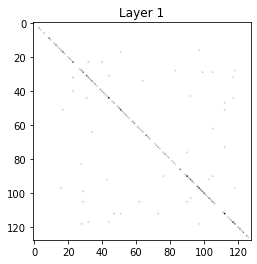

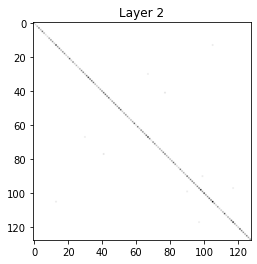

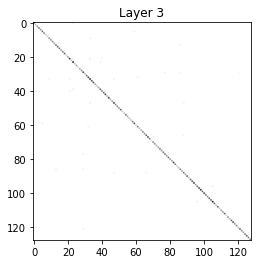

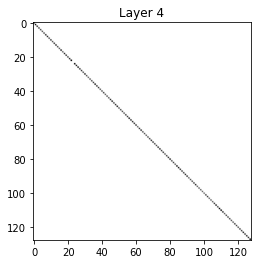

In [32]:
for k,image in enumerate(images):
    plt.imshow(images[k],cmap='Greys')
    plt.title('Layer {}'.format(k+1))
    plt.show()

In [33]:
#similarities and differences between layers...
p = 2 # minkowski distance

x = x_test.numpy()

distances = np.zeros((len(x),len(x)))
for i in range(len(x)):
    for j in range(len(x)):
        distances[i,j] = np.sum(abs(x[i,] - x[j])**p)**(1/p)

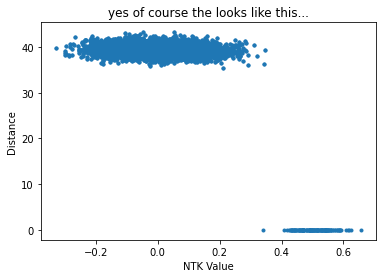

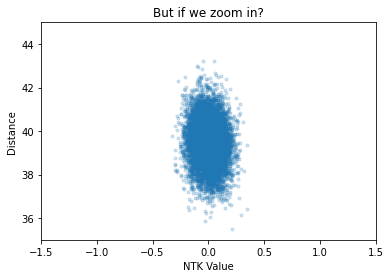

-0.00995605121434715
if W from shapiro Wilks is 1, basically normal:  0.9996227622032166


C:\Users\enge625\Miniconda3\envs\pytorch1.9\lib\site-packages\scipy\stats\morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [34]:
plt.title('yes of course the looks like this...')
plt.plot(l4_NTK.flatten(),distances.flatten(),'.')
plt.ylabel('Distance')
plt.xlabel('NTK Value')
plt.show()


plt.title('But if we zoom in?')
plt.plot(l4_NTK.flatten(),distances.flatten(),'.',alpha=0.1)
plt.ylabel('Distance')
plt.xlabel('NTK Value')
plt.ylim(35,45,)
plt.xlim(-1.5,1.5)
plt.show()

print(np.cov(l4_NTK.flatten()[distances.flatten()!=0],distances.flatten()[distances.flatten()!=0])[0,1])

from scipy.stats import shapiro

print('if W from shapiro Wilks is 1, basically normal: ',shapiro(l4_NTK.flatten()[distances.flatten()!=0])[0])

#### Is the spread in NTK(excluding diagonals) proportional to the number of components used to calculate it? 

In [42]:
layer_components_w4.shape

(128, 32)

Text(0.5, 1.0, 'is the spread in the NTK proportional to the number parameters in each layer?')

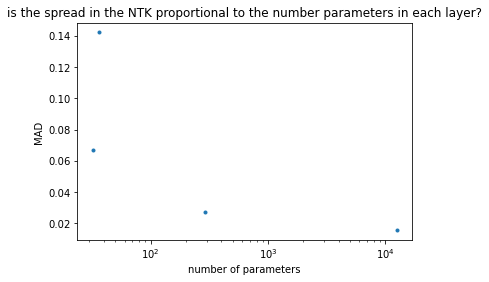

In [46]:
lengths = np.array([np.shape(layer_components_w1)[1],np.shape(layer_components_w2)[1],np.shape(layer_components_w3)[1],np.shape(layer_components_w4)[1]])

def MAD(A):
    
    return np.median(np.abs(np.median(A) - A))

spreads = np.array([MAD(l1_NTK),MAD(l2_NTK),MAD(l3_NTK),MAD(l4_NTK)])

plt.plot(lengths,spreads,'.')
plt.xscale('log')
plt.xlabel('number of parameters')
plt.ylabel('MAD')
plt.title('is the spread in the NTK proportional to the number parameters in each layer?')

### Right, so how many of the elements that are outliers are along the diagonal of the NTK, and does this explain why the number of outliers shared between layers are something like the number of datapoints?

### If we find that many of them are, then this is all just to say, the most influential term in f(x)'s trajectory is x itself, which, duh.

### Look at the histogram of the correaltion matrices for each of these layers datapoints that are shared outliers. Hypothesis is that most of those should be 1.0; and the remainder are part of the normal distribution